# V2: Signal analysis - Multibet
Mutli-bet Strategy: bet 1 whenever signal is given in the specified timeframe

In [7]:
import os
import numpy as np
import pandas as pd
from datetime import datetime,time
import utils as u
from tqdm import tqdm

def signal_data_pipeline(event_id):
    data = pd.read_csv('data/'+event_id+'.csv')
    # data = data[['event_id','minutes','chl_line','chl_hi','chl_low']]
    data = u.remove_empty_rows(data)
    # if remove_empty_rows removes ALL rows, then there will be an empty df
    # to prevent raise of error, only process the pipeline when df is not empty
    # if df is empty, return None
    if data.empty == False:
        data['line_odds'] = data.apply(lambda x: [x.chl_line, x.chl_hi, x.chl_low, x.line_entry], axis = 1)
        odd_list = data[['minutes', 'line_odds']].groupby('minutes')['line_odds'].apply(list).reset_index(name='line_odds')
        data = odd_list.merge(data[['event_id','minutes','total_corner']], how='inner', on='minutes')
        # data = data[['event_id', 'minutes', 'line_odds','total_corner']]

        data['min_odds_info'] = data.line_odds.apply(u.lowest_odd)
        data['line'] = data.min_odds_info.apply(lambda x: x[0])
        data['chl_low'] = data.min_odds_info.apply(lambda x: x[2])
        data['chl_hi'] = data.min_odds_info.apply(lambda x: x[1])
        data['line_entry'] = data.min_odds_info.apply(lambda x: x[3])
        data = data[['event_id','minutes','total_corner','line','chl_hi','chl_low','line_entry']]
        data['minutes'] = data['minutes'].apply(lambda x: datetime.strptime(event_id[:8]+x, "%Y%m%d%H:%M:%S"))
        return data
    else:
        return None


def signal_rules(event_id, data, t, peak_change, multi_bet, exclude_weekdays):
    # create peak df
    data['odd_change'] = data.chl_low/data.chl_low.shift(1)
    # line change
    #data['line_change'] = data.line - data.line.shift(1)
    # is a peak
    data['peak'] = np.where(data.odd_change > 1, 1, 0) # odd_change > 1.01?
    peaks = data[data.peak == 1]
    peaks['peak_change'] = peaks.chl_low/peaks.chl_low.shift(1)
    peaks['peak_change'] = peaks.peak_change.apply(lambda x: round(x,4))

    # apply signal rules---------------------------------------
    peaks['signal'] = np.where(peaks.peak_change < peak_change[0], 1,
                              np.where(peaks.peak_change > peak_change[1],-1,0)) # -1, 0
    
    # signal = 1 means that we predict results will be lower than chl_line, -1 vice versa
    peaks = peaks[peaks.minutes >= datetime.combine(datetime.strptime(event_id[:8],"%Y%m%d"), t[0])]
    peaks = peaks[peaks.minutes <= datetime.combine(datetime.strptime(event_id[:8],"%Y%m%d"), t[1])]
    
    # exclude weekdays
    if exclude_weekdays is not None:
        peaks = peaks[~peaks.event_id.str.contains('|'.join(exclude_weekdays))]
    
    if multi_bet:
        return peaks
    elif peaks.empty==False:
        return peaks.iloc[[0]]
    else:
        return pd.DataFrame({})
    #----------------------------------------------------------


def return_calc(signal_list):
    # merge current results
    result = pd.read_csv('/Users/TysonWu/dev/odds-crawl-app/odds-crawl-app/development/result_collection/match_corner_result.csv')
    signals = signal_list.merge(result[['event_id', 'result_corner', 'league']], how='inner', on='event_id')

    # exclude games without results
    signals = signals[~signals.result_corner.isna()]

    # calculate return
    signals['actual_result'] = np.where(signals.line > signals.result_corner, 1, -1) # 1: low wins, -1: high wins
    signals['correct_prediction'] = np.where(signals.signal == 1,
                                             np.where(signals.line > signals.result_corner, 1, 0),
                                             np.where(signals.signal == 0, None,
                                                      np.where(signals.line < signals.result_corner, 1, 0)))
    signals['return'] = np.where(signals.signal == 1,
                                 np.where(signals.correct_prediction == 1, signals.chl_low-1, -1),
                                 np.where(signals.signal == 0, 0,
                                         np.where(signals.correct_prediction == 1, signals.chl_hi-1, -1)))
    signals['return'] = signals['return'].apply(lambda x: round(x,2))
    signals = signals.sort_values(by='event_id').reset_index(drop=True)
    return signals


def signal_analysis(t=[time(1,10,0),time(1,40,0)], 
                    peak_change=[0.98,1.02],
                    multi_bet=True, 
                    exclude_weekdays=None, 
                    date_range=['20200229','20200315']): # returns a df
    signal_list = None
    # exclude some weekdays and date range--------------
    # date_range
    file_list = [file[:-4] for file in os.listdir('data/') if '2020' in file]
    file_list = [file for file in file_list if ((file[:8] >= date_range[0]) & (file[:8] <= date_range[1]))]
    # exclude_weekdays
#     for weekday in exclude_weekdays:
#         file_list = [file for file in filter(lambda x: weekday not in x, file_list)]
    #---------------------------------------------------
    for event_id in tqdm(file_list):
        # data pipeline
        data = signal_data_pipeline(event_id)
        # signal_data_pipeline returns none when the df is empty after undergo pipeline
        if data is not None:
            peaks = signal_rules(event_id, 
                                 data, 
                                 t, 
                                 peak_change, 
                                 multi_bet, 
                                 exclude_weekdays)
        else: # if df is empty then return an empty peaks df
            peaks = pd.DataFrame({})

        # if peaks df is empty then nothing will be concat
        if signal_list is None:
            if peaks.empty == False:
                signal_list = peaks
        else:
            if peaks.empty == False:
                signal_list = pd.concat([signal_list, peaks], ignore_index=True)

    signals = return_calc(signal_list)
    signals['date'] = signals.event_id.apply(lambda x: x[:8])
    signals['number'] = signals.event_id.apply(lambda x: int(x[11:]))
    signals = signals.sort_values(by=['date','number']).reset_index(drop=True)
    del signals['date']
    del signals['number']
    return signals


def graph_profit(signal):
    u.graph(signal.index, signal['return'].cumsum(), 'Profit over games')


def convert_hilow(num):
    if num == 1:
        return 'L'
    if num == -1:
        return 'H'
    else:
        return ''

# for production: this code currently does not support multibet
def signal_check(driver, event_id, team_name_dict, url, t=time(1,30,0), min_peak_change=0.98, min_peak_change_hi=1, multi_bet=True): # input an event_id of live game and check if it is a bet signal_list
    signal_row = None
    SIGNAL_EMOJI = emoji.emojize(':triangular_flag_on_post:', use_aliases=True)*6

    live_data = signal_data_pipeline(event_id)
    if live_data is not None:
        peaks = signal_rules(event_id, live_data, t, min_peak_change, min_peak_change_hi, multi_bet)
        # if signal != 0 then there is a bet action to take
        peaks = peaks[peaks['signal'] != 0]
        if peaks.empty == False:
            if multi_bet == False:
                # return the first row ie. the first signal row
                signal_row = peaks.iloc[[0]]
                # reset index to row 0
                signal_row = signal_row.reset_index(drop=True)
                # line_entry = str(int(signal_row['line_entry'][0])) # return order of rows
                line = signal_row['line'][0]
                line_xpath = "//*[@id='dCHL"+event_id+"']//*[contains(text(), '["+line+"]')]"
                line_entry = driver.find_elements_by_xpath(line_xpath)[0].get_attribute('id')[-1]
                hilow = convert_hilow(signal_row['signal'][0]) # 1 to L and -1 to H
                # write to database
                # write_to_db(signal_row)
                # also a local file
                if os.path.isfile('data/signals.csv') == True:
                    signals = pd.read_csv('data/signals.csv')
                    signals_exist = signals[signals['event_id']==event_id]
                    # no need to notify and make new entry when there is new signal
                    if signals_exist.empty == False:
                        signals.update(signal_row)
                        signals.to_csv('data/signals.csv', index=False, mode="w", header=True)
                    else:
                        # notify when new signal is found
                        notify('{}\n{}\nSIGNAL FOUND: \n{} vs {}\n{}'.format(
                            SIGNAL_EMOJI, event_id, team_name_dict['home'],
                            team_name_dict['away'], signal_row.T.to_string()))
                        # make auto bet here
                        try:
                            auto_bet(url, event_id, hilow, line_entry)
                        except:
                            notify('{}\nAutobet failed.'.format(event_id))
                        signal_row.to_csv('data/signals.csv', index=False, mode="a", header=False)
                else:
                    # notify when new signal is found
                    notify('{}\n{}\nSIGNAL FOUND: \n{} vs {}\n{}'.format(
                        SIGNAL_EMOJI, event_id, team_name_dict['home'],
                        team_name_dict['away'], signal_row.T.to_string()))
                    # make auto bet here
                    try:
                        auto_bet(url, event_id, hilow, line_entry)
                    except:
                        notify('{}\nAutobet failed.'.format(event_id))
                    signal_row.to_csv('data/signals.csv', index=False, mode="w", header=True)
    else:
        pass


100%|██████████| 109/109 [00:37<00:00,  2.93it/s]


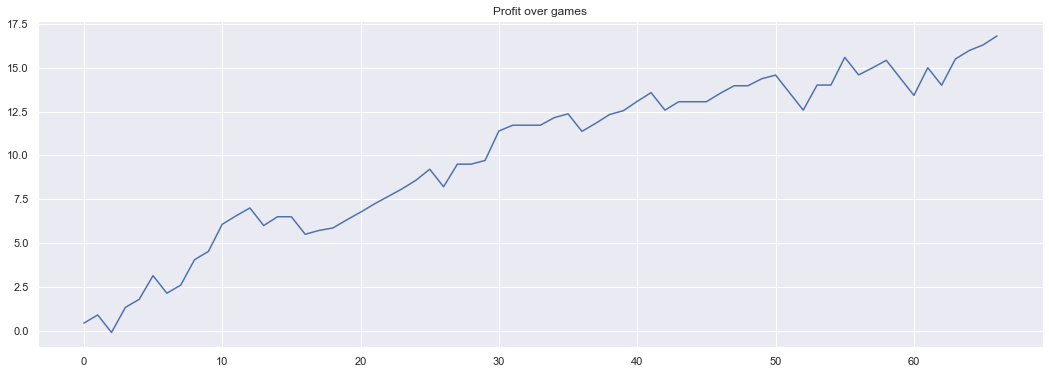

In [8]:
# signal = signal_analysis(t=time(1,10,0), min_peak_change=0.98, min_peak_change_hi=1.02, multi_bet=True)
signal = signal_analysis(t=[time(1,30,0),time(1,45,0)], # list of two datetime.time A<B
                         peak_change=[0.98,1.01], # list of two numbers A<B
                         multi_bet=False, # True or False
                         exclude_weekdays=['SAT'],#['SAT'], # a list, None if no exclusion
                         date_range=['20200201','20201231']) # list of two dates A<B
graph_profit(signal)

In [3]:
signal.tail(15)
# signal[signal.event_id.str.contains("SAT")]

,event_id,minutes,total_corner,line,chl_hi,chl_low,line_entry,odd_change,peak,peak_change,signal,result_corner,league,actual_result,correct_prediction,return
87,20200306FRI1,2020-03-06 01:31:19,4,7.5,2.45,1.48,2.0,1.243697,1,0.9673,1,6.0,Australian Division 1,1,1,0.48
88,20200306FRI4,2020-03-06 01:30:06,12,15.5,3.05,1.32,2.0,1.007634,1,0.9706,1,14.0,German Division 1,1,1,0.32
89,20200307SAT1,2020-03-07 01:37:22,5,8.5,2.35,1.52,2.0,1.245902,1,0.9744,1,8.0,Australian Division 1,1,1,0.52
90,20200307SAT2,2020-03-07 01:32:14,5,7.5,1.84,1.86,1.0,1.388060,1,1.2157,-1,9.0,Australian Division 1,-1,1,0.84
91,20200307SAT5,2020-03-07 01:31:46,6,8.5,2.50,1.46,2.0,1.269565,1,0.9799,1,7.0,Spanish Division 1,1,1,0.46
92,20200307SAT9,2020-03-07 01:34:25,10,13.5,3.05,1.32,2.0,1.031250,1,0.8800,1,13.0,Eng Premier,1,1,0.32
93,20200307SAT16,2020-03-07 01:33:28,6,8.5,2.50,1.46,2.0,1.269565,1,1.0815,-1,8.0,German Division 1,1,0,-1.00
94,20200307SAT21,2020-03-07 01:38:15,12,14.5,3.40,1.27,2.0,1.024194,1,0.8301,1,13.0,Eng Premier,1,1,0.27
95,20200307SAT57,2020-03-07 01:32:12,4,6.5,2.50,1.46,2.0,1.269565,1,0.9299,1,8.0,Eng Premier,-1,0,-1.00
96,20200307SAT58,2020-03-07 01:39:08,6,7.5,2.83,1.37,1.0,1.201754,1,0.9384,1,8.0,Spanish Division 1,-1,0,-1.00


## Thoughts
For this strategy, there are several parameters to be tuned:
1. Enable multi-bet in a game or not
2. Include SAT or not
3. Min time to start observation (t-restriction)
4. Min peak change


In [ ]:
# return analysis
signal[['event_id','return']].groupby('event_id').agg(['sum','count'])

## Return by weekday

In [18]:
signal['weekday'] = signal.event_id.apply(lambda x:x[8:11])
signal[['weekday','return']].groupby('weekday').agg(['sum','count'])

return      
           sum count
weekday             
FRI       0.38     8
MON      -0.50     4
SAT      -8.66    31
SUN       5.21    26
THU       6.44    10
TUE       2.12     9
WED       2.65     9

## Return by League

In [20]:
signal[['league','return']].groupby('league').agg(['sum','count'])

return      
                                  sum count
league                                     
Argentine Division 1            -2.34     5
Asian Champions League           1.83     2
Australian Division 1            1.71    11
Central and North American Cup   0.76     4
Copa Libertadores                3.43     5
Dutch Division 1                 0.43     1
Eng League Cup                   0.00     1
Eng Premier                      0.66    17
French Division 1               -0.72     2
French FA Cup                   -2.00     2
German Cup                       1.01     4
German Division 1                0.23     7
Italian Division 1              -1.87     6
Japanese Division 1             -0.50     2
League                           1.88     2
Mexican Premier                 -1.00     1
South American Cup              -0.53     3
Spanish Division 1               1.44    12
Swedish Cup                     -1.00     1
UE Champions                     0.90     2
UE Cup                           3.92     4
US Football League              -0.60     3